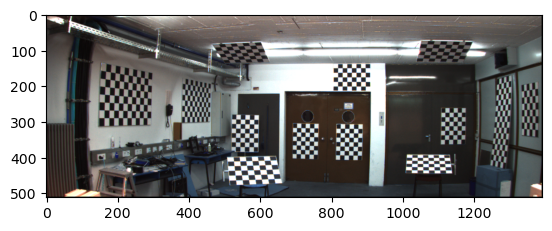

In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import calib_data
calib_path = 'G:/Meine Ablage/UNI/MSc DTU/1. Semester/Perception for Autonomous Systems/FinalProject/data/34759_final_project_raw/calib'
image_02_path = calib_path + '/image_02/data/0000000011.png'
image_03_path = calib_path + '/image_03/data/0000000011.png'

img_02 = cv2.imread(image_02_path)
img_03 = cv2.imread(image_03_path)

chessboard_sizes = [(11, 7), (5, 15), (7, 5)]

plt.imshow(img_02)

Chessboard detected with size (11, 7) in iteration 1


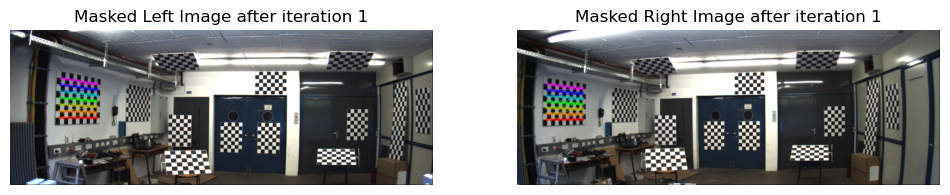

Chessboard detected with size (7, 5) in iteration 2


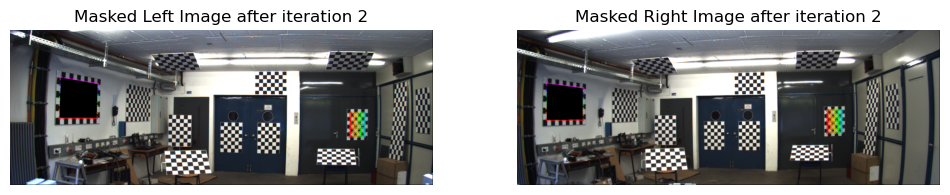

Chessboard detected with size (7, 5) in iteration 3


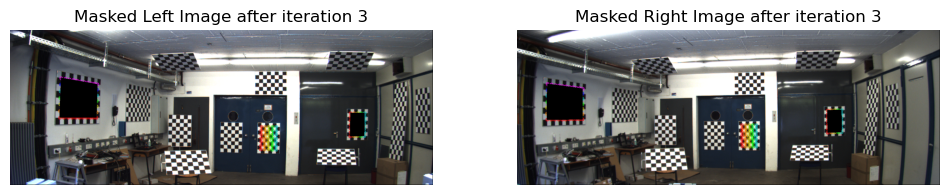

Chessboard detected with size (7, 5) in iteration 4


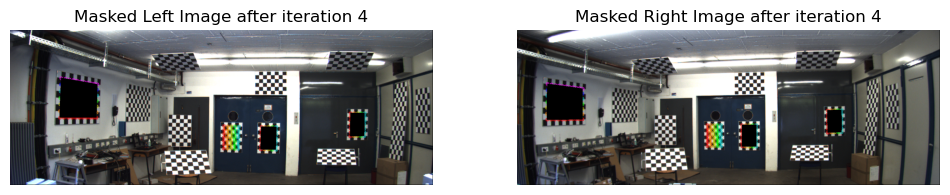

Chessboard detected with size (11, 7) in iteration 5


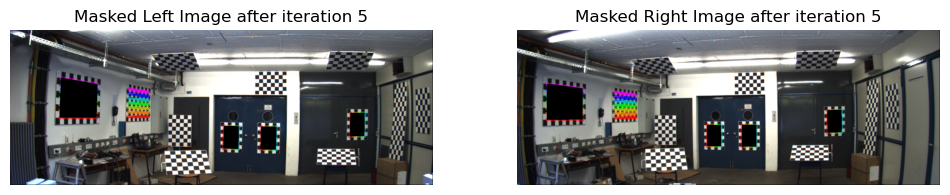

Chessboard detected with size (5, 15) in iteration 6


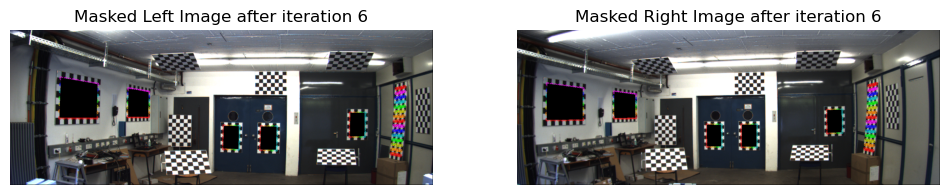

Chessboard detected with size (7, 5) in iteration 7


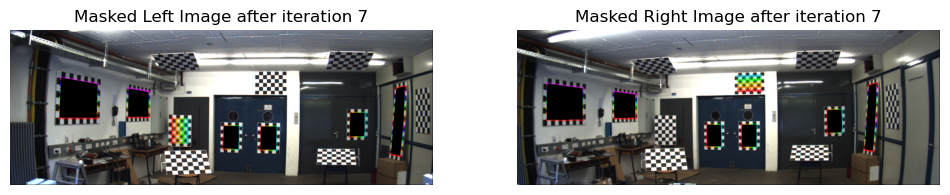

Chessboard detected with size (7, 5) in iteration 8


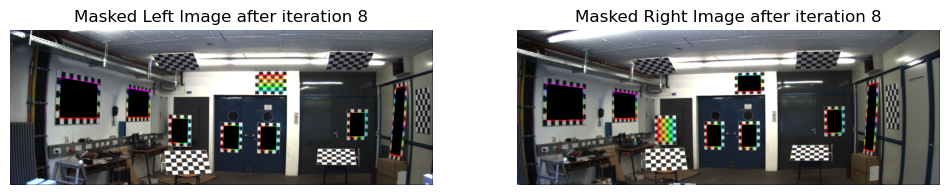

Chessboard detected with size (7, 5) in iteration 9


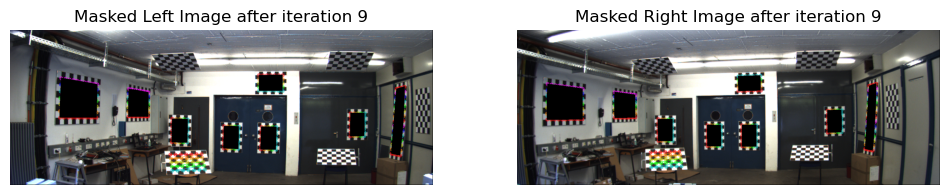

Chessboard detected with size (7, 5) in iteration 10


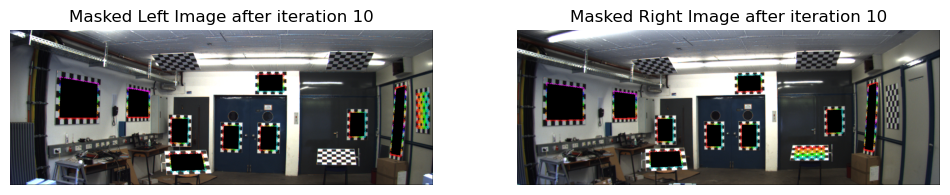

Chessboard detected with size (7, 5) in iteration 11


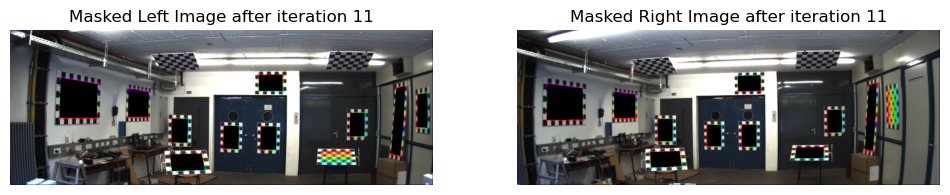

Chessboard detected with size (7, 5) in iteration 12


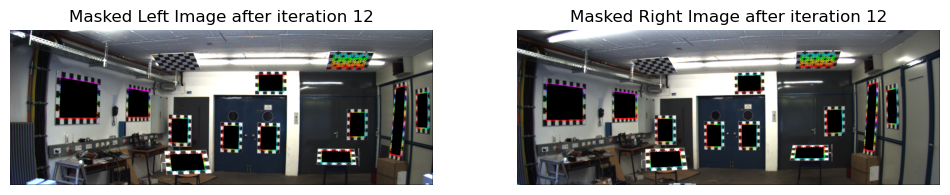

No chessboards found after iteration 12


In [2]:
# Prepare object points based on the expected chessboard dimensions
def prepare_object_points(chessboard_size):
    objp = np.zeros((np.prod(chessboard_size), 3), np.float32)
    objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)
    return objp

# Lists to store points for calibration
objpoints = []  # 3d points in real-world space
imgpoints_left = []  # 2d points in the left image plane
imgpoints_right = []  # 2d points in the right image plane
actual_chessboard_sizes = []

# Function to apply mask to the image (black out detected chessboard area)
def mask_chessboards(image, imgpoints):
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    for corners in imgpoints:
        corners = corners.reshape(-1, 2).astype(np.int32)
        hull = cv2.convexHull(corners)
        cv2.fillConvexPoly(mask, hull, 255)
    masked_image = cv2.bitwise_and(image, image, mask=cv2.bitwise_not(mask))
    return masked_image

left_image = img_02.copy()
right_image = img_03.copy()

detection_flags = cv2.CALIB_CB_EXHAUSTIVE + cv2.CALIB_CB_ACCURACY + cv2.CALIB_CB_NORMALIZE_IMAGE
iteration = 0
# Process both left and right images
while True:
    gray_left = cv2.cvtColor(left_image, cv2.COLOR_BGR2GRAY)
    gray_right = cv2.cvtColor(right_image, cv2.COLOR_BGR2GRAY)

    # Try detecting the chessboard with different patterns in order
    found_left = found_right = False
    chessboard_size = None

    for size in chessboard_sizes:
        found_left, corners_left = cv2.findChessboardCornersSB(gray_left, size, flags=detection_flags)
        found_right, corners_right = cv2.findChessboardCornersSB(gray_right, size, flags=detection_flags)
        
        if found_left and found_right:
            chessboard_size = size
            break

    if chessboard_size is not None and found_left and found_right:
        iteration += 1
        print(f"Chessboard detected with size {chessboard_size} in iteration {iteration}")

        # Prepare object points for the detected chessboard size
        objp = prepare_object_points(chessboard_size)

        # Save object points and image points
        objpoints.append(objp)
        imgpoints_left.append(corners_left)
        imgpoints_right.append(corners_right)
        actual_chessboard_sizes.append(chessboard_size)


        # Draw the detected chessboard for visualization
        cv2.drawChessboardCorners(left_image, chessboard_size, corners_left, found_left)
        cv2.drawChessboardCorners(right_image, chessboard_size, corners_right, found_right)

        # Plot the masked images to visualize the detection
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB))
        axes[0].set_title(f"Masked Left Image after iteration {iteration}")
        axes[0].axis('off')
        axes[1].imshow(cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB))
        axes[1].set_title(f"Masked Right Image after iteration {iteration}")
        axes[1].axis('off')
        plt.show()

        # Apply mask to image
        left_image = mask_chessboards(left_image, imgpoints_left)
        right_image = mask_chessboards(right_image, imgpoints_right)
        
    else:
        print(f"No chessboards found after iteration {iteration}")
        break

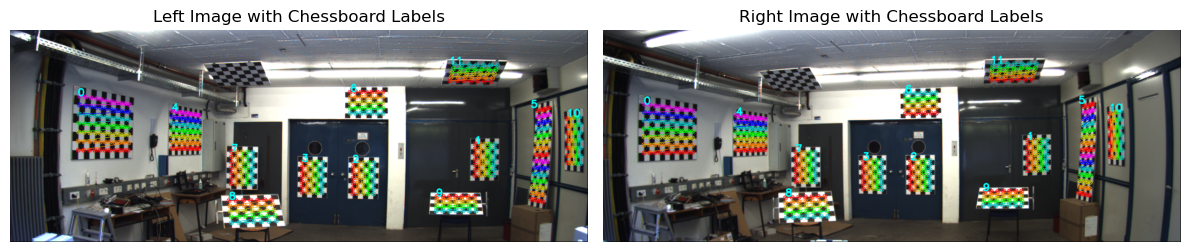

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to swap two elements in a list based on their indices
def swap_elements(lst, index1, index2):
    if index1 < 0 or index1 >= len(lst) or index2 < 0 or index2 >= len(lst):
        raise IndexError("Invalid index")
    lst[index1], lst[index2] = lst[index2], lst[index1]
    return lst

# Function to draw chessboards and label them with their index and size on a given image
def draw_chessboards_with_labels(image, imgpoints, chessboard_sizes):
    # Create a copy of the image to visualize chessboards
    visualized_image = image.copy()

    # Draw all the chessboards and label them with their position and size
    for idx, (corners, size) in enumerate(zip(imgpoints, chessboard_sizes)):
        
        # Draw chessboard corners
        cv2.drawChessboardCorners(visualized_image, size, corners, True)
        
        corners = corners.reshape(-1, 2).astype(np.float32)  # Ensure it's a float32 array

        # Find the corner with the smallest x and y coordinates
        top_left_corner = np.min(corners, axis=0)
        top_left_corner = tuple(top_left_corner)
        top_left_corner = (int(top_left_corner[0]), int(top_left_corner[1]))
            
        # Label the chessboard with its index (1-based index) and size at the top-left corner
        cv2.putText(visualized_image, f'{idx}', 
                        top_left_corner,
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        0.8, (255, 255, 0), 2, cv2.LINE_AA)

    return visualized_image

# create copys
imgpoints_left_new = imgpoints_left.copy()
left_image_new = img_02.copy()
right_image_new = img_03.copy()

# swap elements
imgpoints_left_new = swap_elements(imgpoints_left_new, 6, 7)
imgpoints_left_new = swap_elements(imgpoints_left_new, 9, 10)

imgpoints_right_new = imgpoints_right.copy()

# Draw chessboards with labels on both left and right images
visualized_left_image = draw_chessboards_with_labels(left_image_new, imgpoints_left_new, actual_chessboard_sizes)
visualized_right_image = draw_chessboards_with_labels(right_image_new, imgpoints_right_new, actual_chessboard_sizes)

# Visualize the images with drawn chessboards and labels
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Show left image with labeled chessboards
axes[0].imshow(cv2.cvtColor(visualized_left_image, cv2.COLOR_BGR2RGB))
axes[0].set_title("Left Image with Chessboard Labels")
axes[0].axis('off')

# Show right image with labeled chessboards
axes[1].imshow(cv2.cvtColor(visualized_right_image, cv2.COLOR_BGR2RGB))
axes[1].set_title("Right Image with Chessboard Labels")
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [4]:
left_image = img_02.copy()
right_image = img_03.copy()

h, w = right_image.shape[:2] # same for both cameras

In [ ]:
# Get the camera matrix and distortion coefficients for each camera
ret_left, K_left, D_left, rvecs_left, tvecs_left = cv2.calibrateCamera(objpoints, imgpoints_left_new, left_image.shape[:2], None, None)
ret_right, K_right, D_right, rvecs_right, tvecs_right = cv2.calibrateCamera(objpoints, imgpoints_right_new, right_image.shape[:2], None, None)

# Stereo calibration to get the relative rotation and translation between the cameras
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-5)

print(K_left,'\n', calib_data.K_02)

[[2.40322800e+03 0.00000000e+00 2.30523939e+02]
 [0.00000000e+00 1.40964171e+03 6.78260815e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 
 [[956.9475   0.     693.9767]
 [  0.     952.2352 238.6081]
 [  0.       0.       1.    ]]


In [10]:
correct_values = True

# Perform stereo calibration
if correct_values:
    ret, K_left, D_left, K_right, D_right, R, T, E, F = cv2.stereoCalibrate(
    objpoints, imgpoints_left_new, imgpoints_right_new, calib_data.K_02, calib_data.D_02, calib_data.K_03, calib_data.D_03,
    left_image.shape[:2], criteria=criteria
)
else:
    ret, K_left, D_left, K_right, D_right, R, T, E, F = cv2.stereoCalibrate(
        objpoints, imgpoints_left_new, imgpoints_right_new, K_left, D_left, K_right, D_right,
        left_image.shape[:2], criteria=criteria
    )

# R: Rotation matrix between the two cameras
# T: Translation vector between the two cameras
# E: Essential matrix
# F: Fundamental matrix

# Undistort the images
if correct_values:
    undistorted_left = cv2.undistort(left_image, calib_data.K_02, calib_data.D_02)
    undistorted_right = cv2.undistort(right_image, calib_data.K_03, calib_data.D_03)
else:
    undistorted_left = cv2.undistort(left_image, K_left, D_left)
    undistorted_right = cv2.undistort(right_image, K_right, D_right)

# Get the rectification matrices and projection matrices
if correct_values:
    R2, R3, P2, P3, Q, validPixROI1, validPixROI2 = cv2.stereoRectify(
    calib_data.K_02, calib_data.D_02, calib_data.K_03, calib_data.D_03, (w, h), calib_data.R_02, calib_data.T_02
)
else:
    R2, R3, P2, P3, Q, validPixROI1, validPixROI2 = cv2.stereoRectify(
        K_left, D_left, K_right, D_right, left_image.shape[:2], R, T
    )

# R2, R3: Rotation matrices for the left and right cameras
# P2, P3: Projection matrices for the left and right cameras
# Q: Disparity-to-depth mapping matrix (useful for 3D reconstruction)

# Generate rectification maps
if correct_values:
    map1_left, map2_left = cv2.initUndistortRectifyMap(
        calib_data.K_02, calib_data.D_02, calib_data.R_02, calib_data.P_rect_02, left_image.shape[:2], cv2.CV_32FC1  # Use 32-bit floating point maps
    )

    map1_right, map2_right = cv2.initUndistortRectifyMap(
        calib_data.K_03, calib_data.D_03, calib_data.R_03, calib_data.P_rect_03, right_image.shape[:2], cv2.CV_32FC1  # Use 32-bit floating point maps
    )
else:
    map1_left, map2_left = cv2.initUndistortRectifyMap(
        K_left, D_left, R2, P2, left_image.shape[:2], cv2.CV_32FC1  # Use 32-bit floating point maps
    )

    map1_right, map2_right = cv2.initUndistortRectifyMap(
        K_right, D_right, R3, P3, right_image.shape[:2], cv2.CV_32FC1  # Use 32-bit floating point maps
    )

# Apply the rectification maps
rectified_left = cv2.remap(left_image, map1_left, map2_left, cv2.INTER_LINEAR)
rectified_right = cv2.remap(right_image, map1_right, map2_right, cv2.INTER_LINEAR)


# Apply the rectification maps
rectified_left = cv2.remap(undistorted_left, map1_left, map2_left, cv2.INTER_LINEAR)
rectified_right = cv2.remap(undistorted_right, map1_right, map2_right, cv2.INTER_LINEAR)



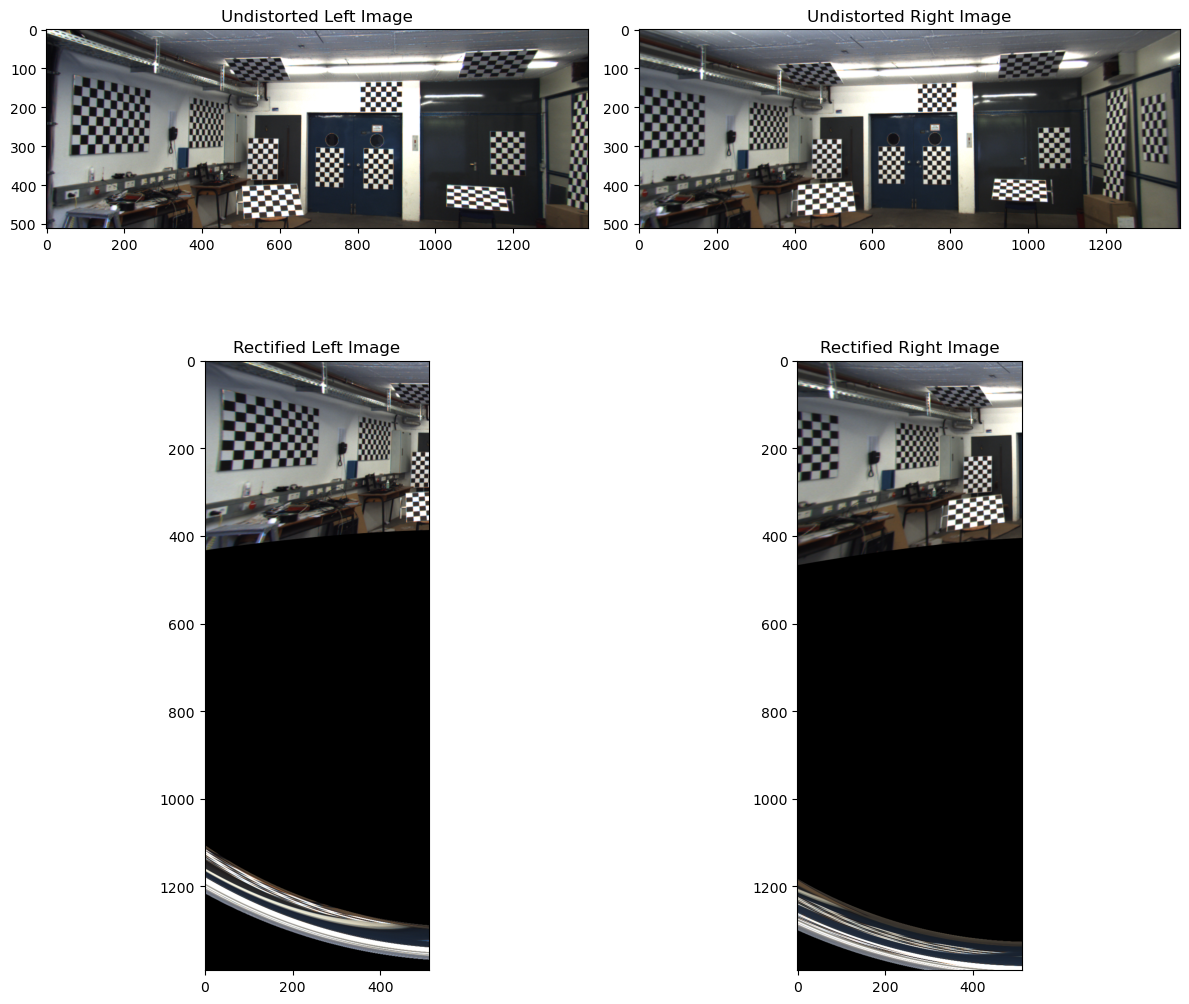

In [11]:
import matplotlib.pyplot as plt

# Plot the undistorted and rectified images
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

# Undistorted Left and Right images
ax[0, 0].imshow(cv2.cvtColor(undistorted_left, cv2.COLOR_BGR2RGB))
ax[0, 0].set_title('Undistorted Left Image')
ax[0, 1].imshow(cv2.cvtColor(undistorted_right, cv2.COLOR_BGR2RGB))
ax[0, 1].set_title('Undistorted Right Image')

# Rectified Left and Right images
ax[1, 0].imshow(cv2.cvtColor(rectified_left, cv2.COLOR_BGR2RGB))
ax[1, 0].set_title('Rectified Left Image')
ax[1, 1].imshow(cv2.cvtColor(rectified_right, cv2.COLOR_BGR2RGB))
ax[1, 1].set_title('Rectified Right Image')

plt.tight_layout()
plt.show()
